In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# import glob
# import os

# path = '../data/raw/seasons/'

# dfs = []

# filenames = glob.glob(os.path.join(path, '*'))

# for file in filenames:
#     dfs.append(pd.read_csv(file, header=0, index_col=None))

# df = pd.concat(dfs, ignore_index=True)

# df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTR']]
# df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
# df.sort_values(by=['Date'], inplace=True)
# df.tail()

In [ ]:
from soccerdata import FBref

fbref = FBref(leagues="GER-Bundesliga", seasons=['20-21', '21-22', '22-23', '23-24', '24-25'], no_store=True)
df = fbref.read_schedule()

df.reset_index().head()

In [ ]:
df = df[['round', 'day', 'date', 'time', 'home_team', 'home_xg', 'score', 'away_team', 'away_xg']]
df.reset_index(inplace=True)
df = df[df['round'] == 'Bundesliga']
df.dropna(axis=0, inplace=True)
df.head()

In [ ]:
import requests

all_teams = df['away_team'].unique()
elo_api_team_names = ['Leverkusen', 'Werder', 'Stuttgart', 'Holstein', 'UnionBerlin',
 'Bochum', 'Frankfurt', 'Bayern', 'Heidenheim', 'StPauli',
 'Gladbach', 'Hoffenheim', 'Wolfsburg', 'Mainz', 'Dortmund', 'RBLeipzig',
 'Augsburg', 'Freiburg', 'Schalke', 'Bielefeld', 'Hertha', 'Koeln',
 'Darmstadt', 'Fuerth']


# Fetch elo data
# for team in elo_api_team_names:
#     r = requests.get(f"http://api.clubelo.com/{team}")
#     if r.status_code == 200:
#         f = open(f"data/team_elos/{team}.csv", 'w')
#         f.write(r.text)
#         f.close()
#     else:
#         print(f"could not find {team}")

team_mapping = {
    'Leverkusen': 'Leverkusen',
    'Werder': 'Werder Bremen',
    'Stuttgart': 'Stuttgart',
    'Holstein': 'Holstein Kiel',
    'UnionBerlin': 'Union Berlin',
    'Bochum': 'Bochum',
    'Frankfurt': 'Eint Frankfurt',
    'Bayern': 'Bayern Munich',
    'Heidenheim': 'Heidenheim',
    'StPauli': 'St. Pauli',
    'Gladbach': 'Gladbach',
    'Hoffenheim': 'Hoffenheim',
    'Wolfsburg': 'Wolfsburg',
    'Mainz': 'Mainz 05',
    'Dortmund': 'Dortmund',
    'RBLeipzig': 'RB Leipzig',
    'Augsburg': 'Augsburg',
    'Freiburg': 'Freiburg',
    'Schalke': 'Schalke 04',
    'Bielefeld': 'Arminia',
    'Hertha': 'Hertha BSC',
    'Koeln': 'Köln',
    'Darmstadt': 'Darmstadt 98',
    'Fuerth': 'Greuther Fürth'
}

In [ ]:
from datetime import datetime

elos = {}
for team in elo_api_team_names:
    mapped_name = team_mapping[team]
    elos[mapped_name] = pd.read_csv(f"../data/raw/team_elos/{team}.csv")[['Elo', 'From', 'To']]
    elos[mapped_name]['From'] = pd.to_datetime(elos[mapped_name]['From'], format='%Y-%m-%d')
    elos[mapped_name]['To'] = pd.to_datetime(elos[mapped_name]['To'], format='%Y-%m-%d')
    date_cutoff = datetime.strptime("01/01/2020", "%d/%m/%Y")
    elos[mapped_name] = elos[mapped_name][elos[mapped_name]['From'] > date_cutoff]
    elos[mapped_name] = elos[mapped_name][elos[mapped_name]['To'] > date_cutoff]

elos['RB Leipzig'].head()

#Check if the mapping is correct
print(list(df['away_team'].unique()).sort() == list(team_mapping.values()).sort())

# Feature Engineering
## Elo_Home, Elo_Away, Elo_Difference

In [ ]:
def fill_ftr(row):
    score = row['score']
    score_components = score.split('–')
    if (int(score_components[0]) > int(score_components[-1])):
        ftr = 'H'
    elif (int(score_components[0]) < int(score_components[-1])):
        ftr = 'A'
    else:
        ftr = 'D'
    return pd.Series({'ftr': ftr})

df['ftr'] = df.apply(fill_ftr, axis=1)

In [ ]:
def get_avg_xG_last_5(date, team):
    '''
        for the first 4 games, the value is a bit skewed since there are
        no 5 last matches. But its is constant for all.
    '''
    filtered_df = df.loc[
        (df['date'] < date) & 
        ((df['away_team'] == team) | (df['home_team'] == team))
    ].sort_values(by='date')

    last_matches = filtered_df.iloc[-5:]
    if last_matches.empty:
        return 0.0

    sum_xG = 0
    for _, match in last_matches.iterrows():
        if match['home_team'] == team:
            sum_xG += match['home_xg']
        else:
            sum_xG += match['away_xg']
    return float(sum_xG / 5)


def fill_avg_xG_last_5(row):
    date = row['date']
    away_team = row['away_team']
    home_team = row['home_team']
    avg_last_5_xG_away = get_avg_xG_last_5(date, away_team)
    avg_last_5_xG_home = get_avg_xG_last_5(date, home_team)
    form_diff = avg_last_5_xG_home - avg_last_5_xG_away
    return pd.Series({'avg_xG_last_5_Home': avg_last_5_xG_home, 'avg_xG_last_5_Away': avg_last_5_xG_away, 'xG_difference': form_diff})

df[['avg_xG_last_5_Home', 'avg_xG_last_5_Away', 'xG_difference']] = df.apply(fill_avg_xG_last_5, axis=1)
df.tail()

In [ ]:
def get_elo(date, elo):
    filtered_df = elo.loc[elo['To'] <= date]
    if filtered_df.empty:
        raise ValueError(f"No Elo available before {date} for team.")
    return filtered_df.iloc[-1]['Elo']

def fill_elo_row(row):
    date = row['date']
    away_team = row['away_team']
    home_team = row['home_team']
    elo_home = get_elo(date, elos[home_team])
    elo_away = get_elo(date, elos[away_team])
    elo_difference = elo_home - elo_away
    return pd.Series({'elo_home': elo_home, 'elo_away': elo_away, 'elo_difference': elo_difference})

df[['elo_home', 'elo_away', 'elo_difference']] = df.apply(fill_elo_row, axis=1)
df.head()

In [ ]:
def plot_elo(teams, start=1990, end=2025):
    dates = pd.date_range(start=f"{start}-01-01", end=f"{end}-12-31", freq='MS')
    date_list = [d.strftime(format='%Y-%m') for d in dates]
    fig, ax = plt.subplots(figsize=(15,6))
    
    for team in teams:
        elo_df = pd.read_csv(f"../data/raw/team_elos/{team}.csv")
        elo_df['From'] = pd.to_datetime(elo_df['From'])
        elos_mean = elo_df.groupby(elo_df['From'].dt.to_period('M'))[['Elo']].mean()
        elo_dates = [str(p) for p in elos_mean.index]
        elos = pd.DataFrame([
            elos_mean.loc[pd.Period(date, freq='M'), 'Elo'] if date in elo_dates else float('nan')
            for date in date_list
        ])
        elos = elos.sort_index()
        elos = elos.bfill()
        ax.plot(date_list, elos.to_numpy(), label=team)
    tick_locs = [i for i, date in enumerate(dates) if date.month == 2 and date.year % 5 == 0]
    tick_labels = [dates[i].strftime('%Y') for i in tick_locs]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.legend()
    plt.show()

#plot_elo(['Dortmund', 'Stuttgart', 'Bayern'])


## Average points last 5 games

In [ ]:
def get_avg_pts_last_5(date, team):
    '''
        for the first 4 games, the value is a bit skewed since there are
        no 5 last matches. But its is constant for all.
    '''
    filtered_df = df.loc[
        (df['date'] < date) & 
        ((df['away_team'] == team) | (df['home_team'] == team))
    ].sort_values(by='date')

    last_matches = filtered_df.iloc[-5:]  # nimm bis zu 5 Spiele
    if last_matches.empty:
        return 0.0

    points = 0
    for _, match in last_matches.iterrows():
        if match['ftr'] == 'D':
            points += 1
        elif (match['ftr'] == 'A' and match['away_team'] == team) or \
             (match['ftr'] == 'H' and match['home_team'] == team):
            points += 3

    return points / 5  # teile durch 5, nicht durch len(last_matches), damit es vergleichbar bleibt


def fill_avg_points_last_5(row):
    date = row['date']
    away_team = row['away_team']
    home_team = row['home_team']
    avg_last_5_points_away = get_avg_pts_last_5(date, away_team)
    avg_last_5_points_home = get_avg_pts_last_5(date, home_team)
    form_diff = avg_last_5_points_home - avg_last_5_points_away
    return pd.Series({'avg_pt_last_5_Home': avg_last_5_points_home, 'avg_pt_last_5_Away': avg_last_5_points_away, 'form_difference': form_diff})

df[['avg_pt_last_5_Home', 'avg_pt_last_5_Away', 'form_difference']] = df.apply(fill_avg_points_last_5, axis=1)
df.tail()



## Winnig streak before this game

In [ ]:
def get_win_streak_flag(date, team, min_streak=2):
    """
    Bestimmt, ob ein Team aktuell auf einer Siegesserie ist (mind. `min_streak` Siege in Folge vor dem gegebenen Datum).
    """
    # Spiele des Teams vor dem gegebenen Datum (absteigend sortiert)
    past_matches = df.loc[
        (df['date'] < date) &
        ((df['home_team'] == team) | (df['away_team'] == team))
    ].sort_values(by='date', ascending=False)

    streak = 0
    for _, match in past_matches.iterrows():
        # Check, ob das Team das Spiel gewonnen hat
        if (match['ftr'] == 'H' and match['home_team'] == team) or \
           (match['ftr'] == 'A' and match['away_team'] == team):
            streak += 1
        else:
            break  # Streak endet beim ersten Nicht-Sieg

    return int(streak >= min_streak)

def fill_win_streak_flags(row):
    """
    Gibt für eine Spielzeile zurück, ob Heim- und Auswärtsteam auf Siegesserien sind.
    """
    date = row['date']
    home_team = row['home_team']
    away_team = row['away_team']

    return pd.Series({
        'on_win_streak_home': get_win_streak_flag(date, home_team),
        'on_win_streak_away': get_win_streak_flag(date, away_team),
        'on_win_streak_difference': get_win_streak_flag(date, home_team) - get_win_streak_flag(date, away_team)
    })

# Anwendung auf das gesamte DataFrame
df[['on_win_streak_home', 'on_win_streak_away', 'on_win_streak_difference']] = df.apply(fill_win_streak_flags, axis=1)
df.tail()

# Add polynomial features

In [546]:
df['elo_form'] = df['elo_difference'] * df['form_difference']
df['form_squared'] = df['form_difference'] ** 2
df['xG_form'] = df['xG_difference'] * df['form_difference']

df.tail()

,index,round,day,date,time,home_team,home_xg,score,away_team,away_xg,...,elo_difference,avg_pt_last_5_Home,avg_pt_last_5_Away,form_difference,on_win_streak_home,on_win_streak_away,on_win_streak_difference,elo_form,form_squared,xG_form
1524,1533,Bundesliga,Sat,2025-05-17,15:30,Heidenheim,1.6,1–4,Werder Bremen,2.2,...,-96.614746,1.4,1.8,-0.4,0,0,0,38.645898,0.16,0.288
1525,1534,Bundesliga,Sat,2025-05-17,15:30,Hoffenheim,0.4,0–4,Bayern Munich,1.4,...,-303.913940,1.0,2.2,-1.2,0,0,0,364.696729,1.44,0.768
1526,1535,Bundesliga,Sat,2025-05-17,15:30,Mainz 05,3.1,2–2,Leverkusen,1.2,...,-148.937500,1.0,1.2,-0.2,0,0,0,29.787500,0.04,-0.100
1527,1536,Bundesliga,Sat,2025-05-17,15:30,RB Leipzig,1.1,2–3,Stuttgart,2.6,...,15.544800,1.2,1.4,-0.2,0,1,-1,-3.108960,0.04,0.180
1528,1537,Bundesliga,Sat,2025-05-17,15:30,St. Pauli,0.8,0–2,Bochum,1.3,...,68.313599,1.2,0.4,0.8,0,0,0,54.650879,0.64,-0.496


In [532]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

def split_data(train_df, numerical_features, target, test_size=0.1, random_state=42):
  '''
    Splitting before scaling is crucial to prevent data leakage!
    Only call fit on the the training set to prevent data leakage!
    Otherwise false sense of accuracy, because through fitting we
    already learn somethong about the test set.
  '''
  X = train_df[numerical_features]
  y = train_df[target].to_numpy().ravel()

  X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=random_state)


  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train_df[numerical_features])
  X_test = scaler.transform(X_test_df[numerical_features])

  encoder = LabelEncoder()
  y_train = encoder.fit_transform(y_train)
  y_test = encoder.transform(y_test)
  print(f"Encoded classes: {encoder.classes_}")
  
  return X_train, X_test, y_train, y_test

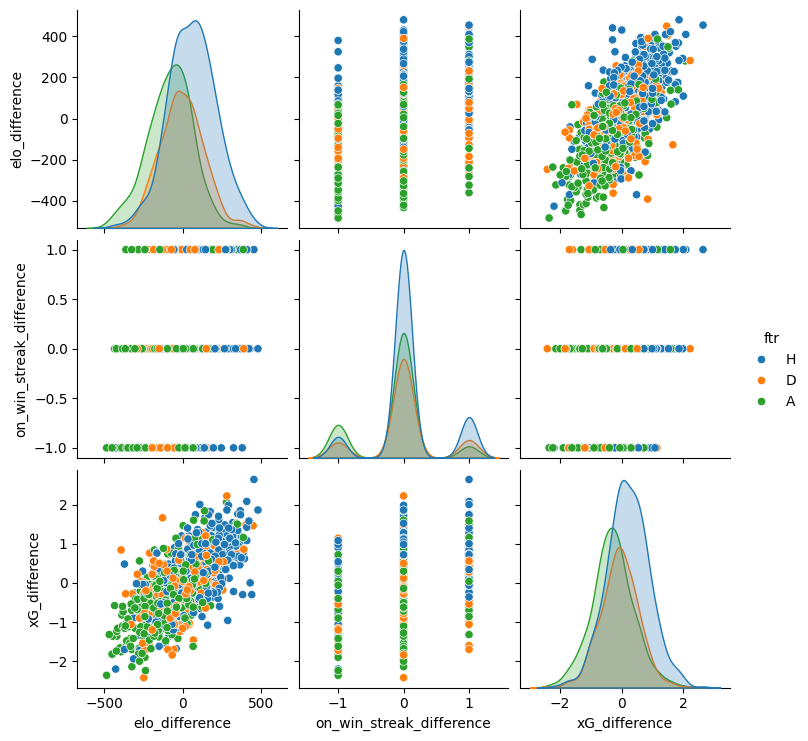

In [548]:
import seaborn as sns
sns.pairplot(data=df[['elo_difference', 'on_win_streak_difference', 'xG_difference', 'ftr']], hue='ftr')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import numpy as np

def evaluate_model(model, X_train, X_test, y_train, y_test, labels=['A', 'D', 'H'], y_pred_override=None):
    # Predict train and test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test) if y_pred_override is None else y_pred_override

    # Handle torch tensors
    if isinstance(y_pred_train, torch.Tensor):
        y_pred_test = np.reshape(y_pred_test.numpy(), len(y_test)) if isinstance(y_pred_test, torch.Tensor) else y_pred_test
        y_pred_train = np.reshape(y_pred_train.numpy(), len(y_train))

    # Accuracy
    train_accuracy = (sum(y_pred_train == y_train) / len(y_train)) * 100
    test_accuracy = (sum(y_pred_test == y_test) / len(y_test)) * 100

    print(f"Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()


Encoded classes: ['A' 'D' 'H']
X_train_shape: (1376, 6),  y_train_shape: (1376,)
X_test_shape: (153, 6),  y_test_shape: (153,)
Test accuracy: 0.49019607843137253
Cross Validation score: 0.49855599472990775
Train accuracy: 55.16, Test accuracy: 49.02


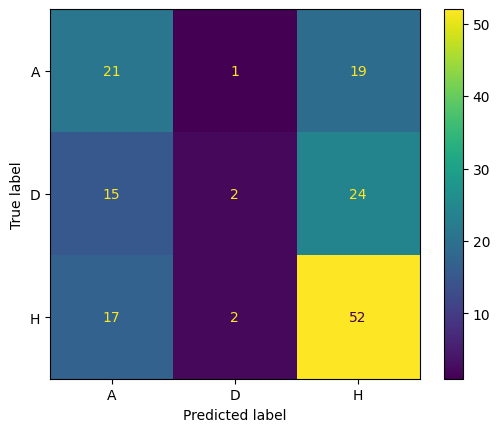

In [547]:
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = split_data(df, ['elo_difference', 'form_difference', 'xG_difference', 'on_win_streak_difference', 'elo_form', 'xG_form'], 'ftr')
print(F"X_train_shape: {X_train.shape},  y_train_shape: {y_train.shape}")
print(F"X_test_shape: {X_test.shape},  y_test_shape: {y_test.shape}")

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    max_depth=3,           
    n_estimators=20,       
    learning_rate=0.1      
)

xgb_clf.fit(X_train, y_train)

y_pred_test = xgb_clf.predict(X_test)
print(f"Test accuracy: {metrics.accuracy_score(y_pred=y_pred_test, y_true=y_test)}")

scores = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross Validation score: {scores.mean()}")

evaluate_model(xgb_clf, X_train, X_test, y_train, y_test)

Encoded classes: ['A' 'D' 'H']
X_train_shape: (1376, 4),  y_train_shape: (1376,)
X_test_shape: (153, 4),  y_test_shape: (153,)
Classification report:
              precision    recall  f1-score   support

           0       0.39      0.54      0.45        41
           1       0.25      0.20      0.22        41
           2       0.56      0.51      0.53        71

    accuracy                           0.43       153
   macro avg       0.40      0.41      0.40       153
weighted avg       0.43      0.43      0.43       153



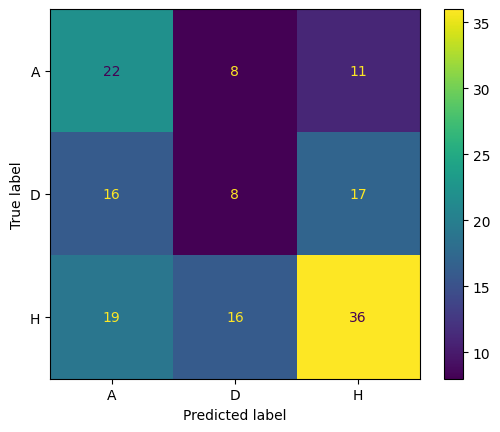

In [543]:
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

# 1. Split data
X_train, X_test, y_train, y_test = split_data(
    df,
    ['elo_difference', 'form_difference', 'xG_difference', 'on_win_streak_difference'],
    'ftr'
)
print(f"X_train_shape: {X_train.shape},  y_train_shape: {y_train.shape}")
print(f"X_test_shape: {X_test.shape},  y_test_shape: {y_test.shape}")

# 2. Handle class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 3. Define and train model
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    max_depth=3,
    n_estimators=20,
    learning_rate=0.1
)
xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)

# 4. Predict probabilities
y_pred_proba = xgb_clf.predict_proba(X_test)

# 5. Apply custom thresholding logic
def thresholded_predict(p, threshold=0.3):
    if np.max(p) < threshold:
        return 1  # class 1 = Draw
    return np.argmax(p)

y_pred_thresh = np.array([thresholded_predict(p) for p in y_pred_proba])

# 6. Evaluation
print(f"Classification report:\n{metrics.classification_report(y_test, y_pred_thresh)}")

cm = confusion_matrix(y_test, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A','D','H'])
disp.plot()


